# Adaption to new classes
project 7 by Guanzhao Wang, Haochen Wu, Yukai Wang

## Part 2: ResNet model training

in this part, the Neural Network is replaced from our CNN to pre-trained ResNet. The purpose is to compare between neural networks. The result of ResNet is not good. So, we decide to use our CNN in the main part.

In [1]:
from mylibs.dataloader import getTrainValidateLoaders, getTestLoaders
from mylibs.train import train
from mylibs.eval import validate
from mylibs.model import Net, CustomFashionResNet
from mylibs.loss import loss_function
from mylibs.report import report_epoch_summary, report_summary, report_test_summary

import torch
from torchvision import transforms
import os

In [2]:
USE_GPU = True
BATCH_SIZE = 64
EPOCH = 30
NUM_WORKERS = 2
K = 7

In [3]:
device = torch.device("cuda" if USE_GPU else "cpu")

transform = transforms.Compose([
    transforms.ToTensor()
])

mode_description = {0: "clustering: kmeans",
                    1: "clustering: kmeans with PCA",
                    2: "clustering: kmeans with Auto Encoder",
                    3: "clustering: Gaussian Mixture",
                    4: "clustering: Gaussian Mixture with PCA",
                    5: "clustering: Gaussian Mixture with Auto Encoder",
                    6: "use only labeled data",
                    7: "use full FasionMNIST data",
                   }

mode_description_short = {0: "Kmeans",
                          1: "Kmeans with PCA",
                          2: "Kmeans with Auto Encoder",
                          3: "Gaussian Mixture",
                          4: "Gaussian Mixture with PCA",
                          5: "Gaussian Mixture with Auto Encoder",
                          6: "Labeled data only",
                          7: "Full FasionMNIST",
                         }

mode_metrics = {}
mode_test_metrics = {}

In [4]:
def whole_flow(mode, useResnet):
    global mode_metrics
    print(f"Getting train and validate dataloaders for mode {mode}: {mode_description[mode]}")
    train_val_loaders = getTrainValidateLoaders(include_labels=range(K), transform=transform, batch_size=BATCH_SIZE, split=0.9, num_workers=NUM_WORKERS, mode=mode, USE_GPU=USE_GPU)
    if useResnet:
        model = CustomFashionResNet(color_scale = 1, num_classes = 10).to(device)
    else:
        model = Net().to(device)
    optimizer = torch.optim.Adadelta(model.parameters(), lr=0.01)
    eval_metrics = []

    model_name = "ResNet" if useResnet else "Net"
    checkpoint_path = f"./checkpoint/mode_{mode}/{model_name}"
    os.makedirs(checkpoint_path, exist_ok=True)
    
    print(f"Start Training... {model_name}")
    # scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
    for epoch in range(1, EPOCH+1):
        eval_metric = train(train_val_loaders, model, loss_function, optimizer, USE_GPU, f"{checkpoint_path}/epoch_{epoch}.pt")
        eval_metrics.append(eval_metric)
        print(f"Epoch: {epoch}")
        print(f"\tTrain      - Loss: {eval_metric['train']['loss']:.4f} Accuracy: {eval_metric['train']['acc']:.4f} F1_score: {eval_metric['train']['f1']:.4f}")
        print(f"\tValidation - Loss: {eval_metric['val']['loss']:.4f} Accuracy: {eval_metric['val']['acc']:.4f} F1_score: {eval_metric['val']['f1']:.4f}")

    report_epoch_summary(eval_metrics)
    
    all_val_f1 = [x['val']['f1'] for x in eval_metrics]
    best_epoch = all_val_f1.index(max(all_val_f1)) + 1
    print(f"Loading model at epoch {best_epoch} for best validation f1")
    checkpoint = torch.load(f"{checkpoint_path}/epoch_{epoch}.pt")
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    print("Preparing test loaders")
    labeled_test_loader, unlabeled_test_loader, test_loader = getTestLoaders(include_labels=range(K), transform=transform, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, USE_GPU=USE_GPU)
    
    model.eval()
    eval_metric = validate(labeled_test_loader, model, loss_function, USE_GPU)
    print(f"Result on labelled test set  : Loss: {eval_metric['loss']:.4f} Accuracy: {eval_metric['acc']:.4f} F1_score: {eval_metric['f1']:.4f}")

    eval_metric = validate(unlabeled_test_loader, model, loss_function, USE_GPU)
    print(f"Result on unlabelled test set: Loss: {eval_metric['loss']:.4f} Accuracy: {eval_metric['acc']:.4f} F1_score: {eval_metric['f1']:.4f}")

    eval_metric = validate(test_loader, model, loss_function, USE_GPU)
    print(f"Result on full test set      : Loss: {eval_metric['loss']:.4f} Accuracy: {eval_metric['acc']:.4f} F1_score: {eval_metric['f1']:.4f}")
    
    mode_metrics[mode] = eval_metrics
    mode_test_metrics[mode] = eval_metric


## Baseline #1, use only first K-class labelled data to train

Getting train and validate dataloaders for mode 6: use only labeled data
Start Training... ResNet
Epoch: 1
	Train      - Loss: 1.9306 Accuracy: 0.4626 F1_score: 0.4133
	Validation - Loss: 1.5597 Accuracy: 0.5676 F1_score: 0.4750
Epoch: 2
	Train      - Loss: 1.2985 Accuracy: 0.6270 F1_score: 0.5527
	Validation - Loss: 1.0706 Accuracy: 0.6767 F1_score: 0.6212
Epoch: 3
	Train      - Loss: 0.9415 Accuracy: 0.6951 F1_score: 0.6558
	Validation - Loss: 0.8223 Accuracy: 0.7274 F1_score: 0.6972
Epoch: 4
	Train      - Loss: 0.7693 Accuracy: 0.7330 F1_score: 0.7085
	Validation - Loss: 0.6914 Accuracy: 0.7483 F1_score: 0.7232
Epoch: 5
	Train      - Loss: 0.6605 Accuracy: 0.7651 F1_score: 0.7488
	Validation - Loss: 0.6072 Accuracy: 0.7829 F1_score: 0.7698
Epoch: 6
	Train      - Loss: 0.5830 Accuracy: 0.7987 F1_score: 0.7907
	Validation - Loss: 0.5405 Accuracy: 0.8110 F1_score: 0.8033
Epoch: 7
	Train      - Loss: 0.5238 Accuracy: 0.8198 F1_score: 0.8149
	Validation - Loss: 0.4920 Accuracy: 0.8283 F1

<Figure size 432x288 with 0 Axes>

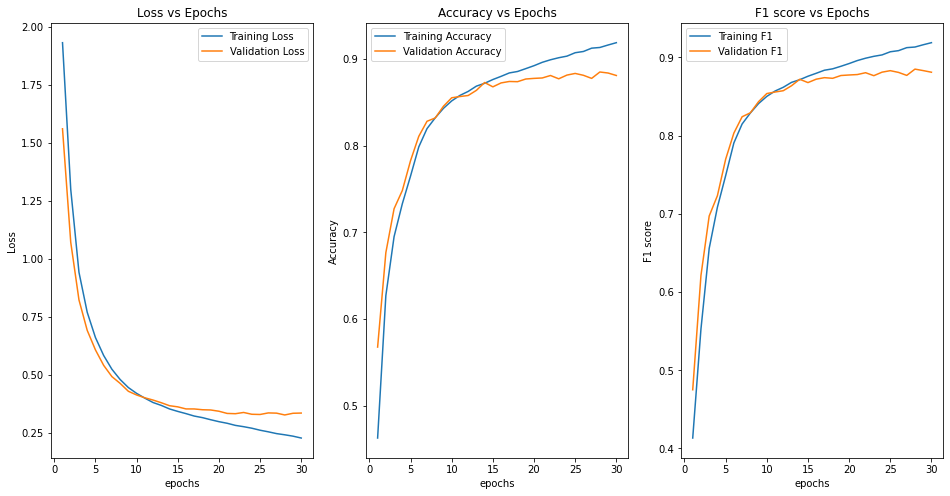

Loading model at epoch 28 for best validation f1
Preparing test loaders
Result on labelled test set  : Loss: 0.3572 Accuracy: 0.8726 F1_score: 0.8729
Result on unlabelled test set: Loss: 9.4141 Accuracy: 0.0000 F1_score: 0.0000
Result on full test set      : Loss: 3.0787 Accuracy: 0.6108 F1_score: 0.5264


In [5]:
whole_flow(6, True)

## Baseline #2, use full Fashion-MNIST dataset to train

Getting train and validate dataloaders for mode 7: use full FasionMNIST data
Start Training... ResNet
Epoch: 1
	Train      - Loss: 1.9156 Accuracy: 0.5571 F1_score: 0.5593
	Validation - Loss: 1.5457 Accuracy: 0.6812 F1_score: 0.6666
Epoch: 2
	Train      - Loss: 1.2603 Accuracy: 0.6990 F1_score: 0.6801
	Validation - Loss: 1.0255 Accuracy: 0.7202 F1_score: 0.7013
Epoch: 3
	Train      - Loss: 0.8744 Accuracy: 0.7535 F1_score: 0.7366
	Validation - Loss: 0.7502 Accuracy: 0.7685 F1_score: 0.7517
Epoch: 4
	Train      - Loss: 0.6742 Accuracy: 0.7848 F1_score: 0.7711
	Validation - Loss: 0.6113 Accuracy: 0.7913 F1_score: 0.7781
Epoch: 5
	Train      - Loss: 0.5643 Accuracy: 0.8130 F1_score: 0.8042
	Validation - Loss: 0.5257 Accuracy: 0.8210 F1_score: 0.8140
Epoch: 6
	Train      - Loss: 0.4893 Accuracy: 0.8368 F1_score: 0.8320
	Validation - Loss: 0.4731 Accuracy: 0.8385 F1_score: 0.8337
Epoch: 7
	Train      - Loss: 0.4351 Accuracy: 0.8539 F1_score: 0.8505
	Validation - Loss: 0.4266 Accuracy: 0.853

<Figure size 432x288 with 0 Axes>

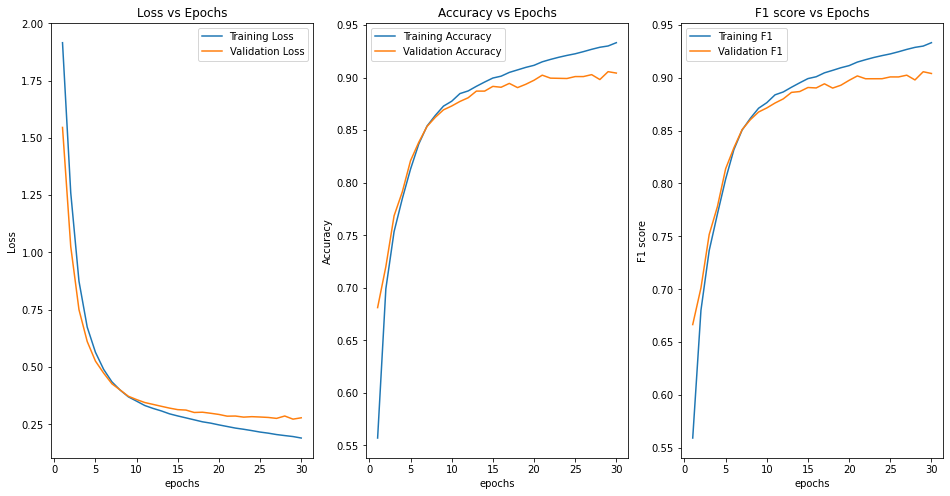

Loading model at epoch 29 for best validation f1
Preparing test loaders
Result on labelled test set  : Loss: 0.3777 Accuracy: 0.8690 F1_score: 0.8719
Result on unlabelled test set: Loss: 0.0975 Accuracy: 0.9683 F1_score: 0.9741
Result on full test set      : Loss: 0.2934 Accuracy: 0.8988 F1_score: 0.8984


In [6]:
whole_flow(7, True)

# Label new categories by clustering

- label the dataset under different clustering methods
- compare acuracy on the test set

## Approach #1, use KMeans to compute label for unlabelled data

Getting train and validate dataloaders for mode 0: clustering: kmeans
Labeling unlabeled data...
Labeling accuracy: 0.8799444444444444
Start Training... ResNet
Epoch: 1
	Train      - Loss: 1.9291 Accuracy: 0.4805 F1_score: 0.4409
	Validation - Loss: 1.5497 Accuracy: 0.6390 F1_score: 0.6023
Epoch: 2
	Train      - Loss: 1.2419 Accuracy: 0.7092 F1_score: 0.6905
	Validation - Loss: 0.9784 Accuracy: 0.7560 F1_score: 0.7432
Epoch: 3
	Train      - Loss: 0.8392 Accuracy: 0.7551 F1_score: 0.7412
	Validation - Loss: 0.7171 Accuracy: 0.7788 F1_score: 0.7695
Epoch: 4
	Train      - Loss: 0.6636 Accuracy: 0.7791 F1_score: 0.7680
	Validation - Loss: 0.5943 Accuracy: 0.8025 F1_score: 0.7953
Epoch: 5
	Train      - Loss: 0.5626 Accuracy: 0.8046 F1_score: 0.7969
	Validation - Loss: 0.5180 Accuracy: 0.8263 F1_score: 0.8216
Epoch: 6
	Train      - Loss: 0.4937 Accuracy: 0.8295 F1_score: 0.8250
	Validation - Loss: 0.4609 Accuracy: 0.8468 F1_score: 0.8440
Epoch: 7
	Train      - Loss: 0.4466 Accuracy: 0.8435 F

<Figure size 432x288 with 0 Axes>

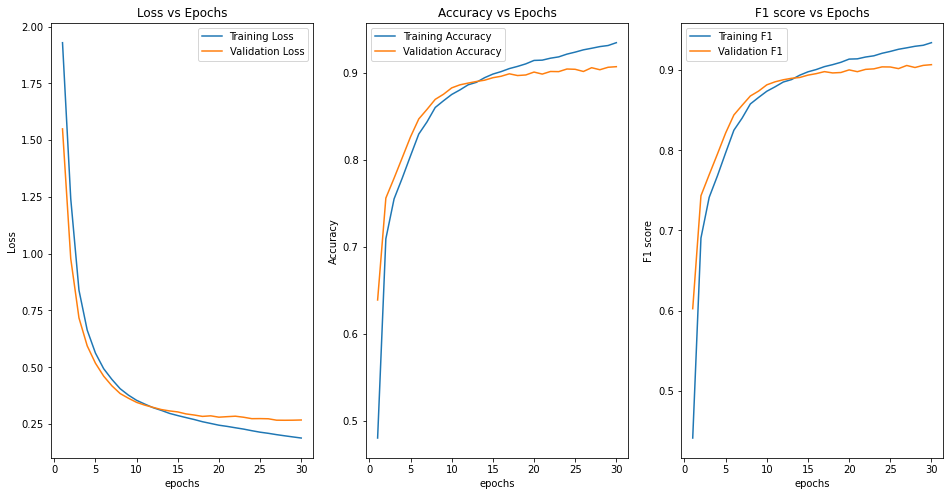

Loading model at epoch 30 for best validation f1
Preparing test loaders
Result on labelled test set  : Loss: 0.3637 Accuracy: 0.8716 F1_score: 0.8742
Result on unlabelled test set: Loss: 0.6130 Accuracy: 0.8737 F1_score: 0.8823
Result on full test set      : Loss: 0.4424 Accuracy: 0.8722 F1_score: 0.8729


In [7]:
whole_flow(0, True)

## Approach #2, use KMeans with PCA to compute label for unlabelled data

Getting train and validate dataloaders for mode 1: clustering: kmeans with PCA
Labeling unlabeled data...
Labeling accuracy: 0.8811111111111111
Start Training... ResNet
Epoch: 1
	Train      - Loss: 1.9170 Accuracy: 0.4582 F1_score: 0.4258
	Validation - Loss: 1.5401 Accuracy: 0.6160 F1_score: 0.5838
Epoch: 2
	Train      - Loss: 1.2525 Accuracy: 0.6877 F1_score: 0.6648
	Validation - Loss: 0.9935 Accuracy: 0.7392 F1_score: 0.7165
Epoch: 3
	Train      - Loss: 0.8581 Accuracy: 0.7468 F1_score: 0.7288
	Validation - Loss: 0.7403 Accuracy: 0.7682 F1_score: 0.7522
Epoch: 4
	Train      - Loss: 0.6837 Accuracy: 0.7726 F1_score: 0.7592
	Validation - Loss: 0.6155 Accuracy: 0.7907 F1_score: 0.7813
Epoch: 5
	Train      - Loss: 0.5823 Accuracy: 0.8010 F1_score: 0.7929
	Validation - Loss: 0.5355 Accuracy: 0.8172 F1_score: 0.8115
Epoch: 6
	Train      - Loss: 0.5054 Accuracy: 0.8290 F1_score: 0.8246
	Validation - Loss: 0.4708 Accuracy: 0.8428 F1_score: 0.8387
Epoch: 7
	Train      - Loss: 0.4478 Accuracy:

<Figure size 432x288 with 0 Axes>

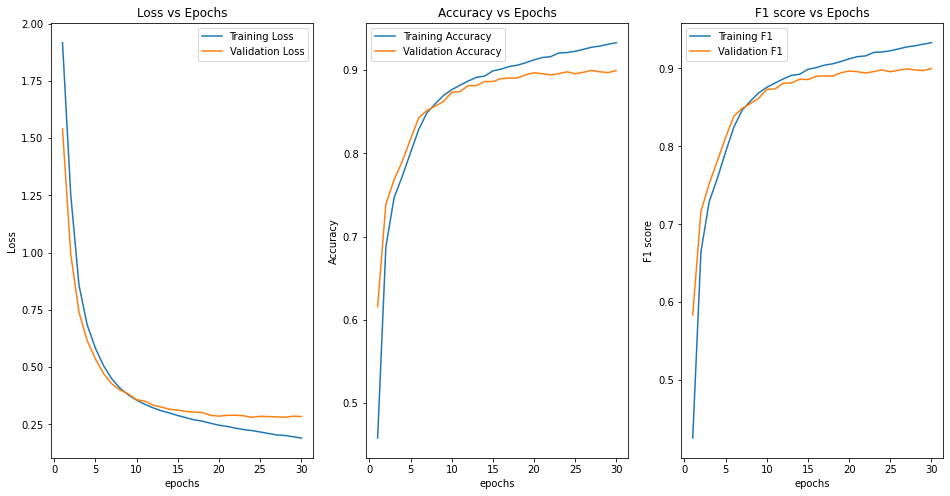

Loading model at epoch 30 for best validation f1
Preparing test loaders
Result on labelled test set  : Loss: 0.3700 Accuracy: 0.8691 F1_score: 0.8723
Result on unlabelled test set: Loss: 0.5518 Accuracy: 0.8797 F1_score: 0.8892
Result on full test set      : Loss: 0.4247 Accuracy: 0.8723 F1_score: 0.8733


In [8]:
whole_flow(1, True)

## Approach #3, use KMeans with Auto Encoder to compute label for unlabelled data

Getting train and validate dataloaders for mode 2: clustering: kmeans with Auto Encoder
Labeling unlabeled data...
Training Auto Encoder...


/ssd/jason_ssd/AdaptToNewClass/mylibs/loss.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log2pi = torch.log(torch.tensor(2.0 * torch.as_tensor(np.pi)))
/ssd/jason_ssd/AdaptToNewClass/mylibs/loss.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.sum(-0.5 * ((sample - mean) ** 2.0 * torch.exp(torch.tensor(-logvar)) + logvar + log2pi), dim=raxis)


Epoch: 1 Loss: {'loss': 356.0547530924479}
Epoch: 2 Loss: {'loss': 321.3297322265625}
Epoch: 3 Loss: {'loss': 318.8270221191406}
Epoch: 4 Loss: {'loss': 317.85027114257815}
Epoch: 5 Loss: {'loss': 317.0417849121094}
Epoch: 6 Loss: {'loss': 316.6882287109375}
Epoch: 7 Loss: {'loss': 316.0896029622396}
Epoch: 8 Loss: {'loss': 315.8089850911458}
Epoch: 9 Loss: {'loss': 315.3270469075521}
Epoch: 10 Loss: {'loss': 315.0863637532552}
Epoch: 11 Loss: {'loss': 315.12866446940103}
Epoch: 12 Loss: {'loss': 314.92135056966146}
Epoch: 13 Loss: {'loss': 314.81359272460935}
Epoch: 14 Loss: {'loss': 314.7329821126302}
Epoch: 15 Loss: {'loss': 314.628393766276}
Labeling accuracy: 0.3397777777777778
Start Training... ResNet
Epoch: 1
	Train      - Loss: 2.0030 Accuracy: 0.3599 F1_score: 0.2859
	Validation - Loss: 1.7137 Accuracy: 0.4540 F1_score: 0.3771
Epoch: 2
	Train      - Loss: 1.4915 Accuracy: 0.5155 F1_score: 0.4510
	Validation - Loss: 1.2921 Accuracy: 0.5625 F1_score: 0.4990
Epoch: 3
	Train      

<Figure size 432x288 with 0 Axes>

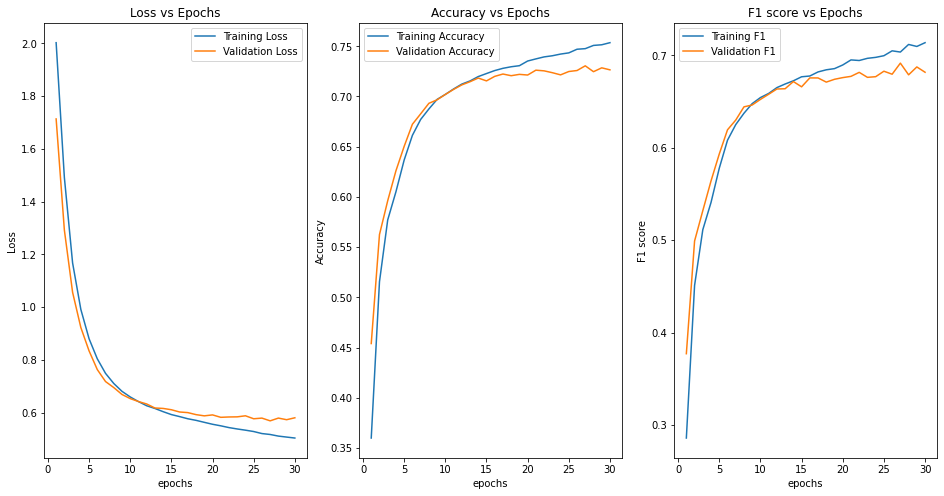

Loading model at epoch 27 for best validation f1
Preparing test loaders
Result on labelled test set  : Loss: 0.3664 Accuracy: 0.8707 F1_score: 0.8736
Result on unlabelled test set: Loss: 1.1532 Accuracy: 0.3393 F1_score: 0.2093
Result on full test set      : Loss: 0.6043 Accuracy: 0.7113 F1_score: 0.6698


In [13]:
whole_flow(2, True)

## Approach #4, use Gaussian Mixture to compute label for unlabelled data

Getting train and validate dataloaders for mode 3: clustering: Gaussian Mixture
Labeling unlabeled data...
Labeling accuracy: 0.8389444444444445
Start Training... ResNet
Epoch: 1
	Train      - Loss: 1.9841 Accuracy: 0.4972 F1_score: 0.4512
	Validation - Loss: 1.6337 Accuracy: 0.6433 F1_score: 0.6021
Epoch: 2
	Train      - Loss: 1.3083 Accuracy: 0.7031 F1_score: 0.6745
	Validation - Loss: 1.0294 Accuracy: 0.7448 F1_score: 0.7192
Epoch: 3
	Train      - Loss: 0.8740 Accuracy: 0.7579 F1_score: 0.7369
	Validation - Loss: 0.7450 Accuracy: 0.7738 F1_score: 0.7549
Epoch: 4
	Train      - Loss: 0.6764 Accuracy: 0.7821 F1_score: 0.7671
	Validation - Loss: 0.6110 Accuracy: 0.7943 F1_score: 0.7812
Epoch: 5
	Train      - Loss: 0.5661 Accuracy: 0.8090 F1_score: 0.7990
	Validation - Loss: 0.5205 Accuracy: 0.8238 F1_score: 0.8178
Epoch: 6
	Train      - Loss: 0.4920 Accuracy: 0.8358 F1_score: 0.8309
	Validation - Loss: 0.4614 Accuracy: 0.8437 F1_score: 0.8405
Epoch: 7
	Train      - Loss: 0.4379 Accuracy

<Figure size 432x288 with 0 Axes>

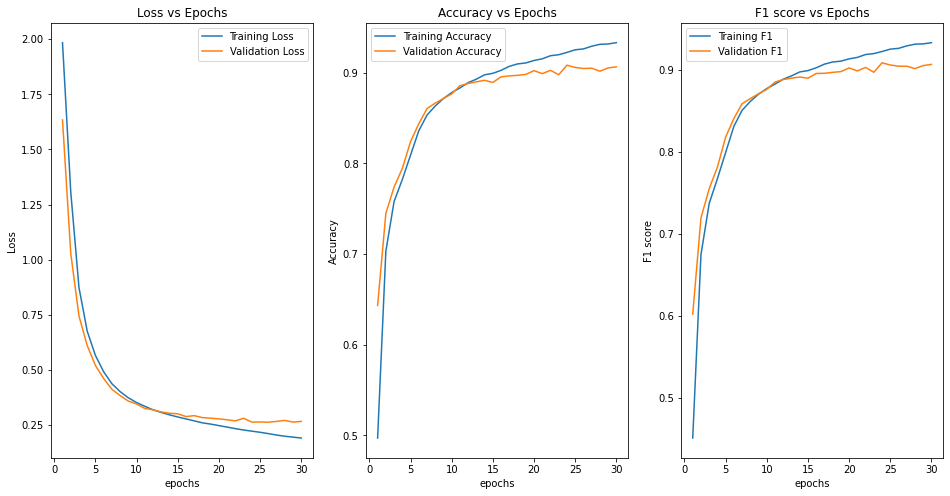

Loading model at epoch 24 for best validation f1
Preparing test loaders
Result on labelled test set  : Loss: 0.3543 Accuracy: 0.8730 F1_score: 0.8753
Result on unlabelled test set: Loss: 1.0503 Accuracy: 0.8207 F1_score: 0.8262
Result on full test set      : Loss: 0.5620 Accuracy: 0.8573 F1_score: 0.8565


In [9]:
whole_flow(3, True)

## Approach #5, use Gaussian Mixture with PCA to compute label for unlabelled data

Getting train and validate dataloaders for mode 4: clustering: Gaussian Mixture with PCA
Labeling unlabeled data...
Labeling accuracy: 0.6936111111111111
Start Training... ResNet
Epoch: 1
	Train      - Loss: 1.8489 Accuracy: 0.4782 F1_score: 0.4468
	Validation - Loss: 1.4464 Accuracy: 0.5817 F1_score: 0.5269
Epoch: 2
	Train      - Loss: 1.2142 Accuracy: 0.6601 F1_score: 0.6288
	Validation - Loss: 1.0253 Accuracy: 0.7063 F1_score: 0.6739
Epoch: 3
	Train      - Loss: 0.8941 Accuracy: 0.7327 F1_score: 0.7087
	Validation - Loss: 0.7910 Accuracy: 0.7502 F1_score: 0.7291
Epoch: 4
	Train      - Loss: 0.7079 Accuracy: 0.7761 F1_score: 0.7600
	Validation - Loss: 0.6461 Accuracy: 0.7813 F1_score: 0.7649
Epoch: 5
	Train      - Loss: 0.5930 Accuracy: 0.8020 F1_score: 0.7909
	Validation - Loss: 0.5568 Accuracy: 0.8095 F1_score: 0.8010
Epoch: 6
	Train      - Loss: 0.5160 Accuracy: 0.8265 F1_score: 0.8202
	Validation - Loss: 0.4926 Accuracy: 0.8350 F1_score: 0.8303
Epoch: 7
	Train      - Loss: 0.4613

<Figure size 432x288 with 0 Axes>

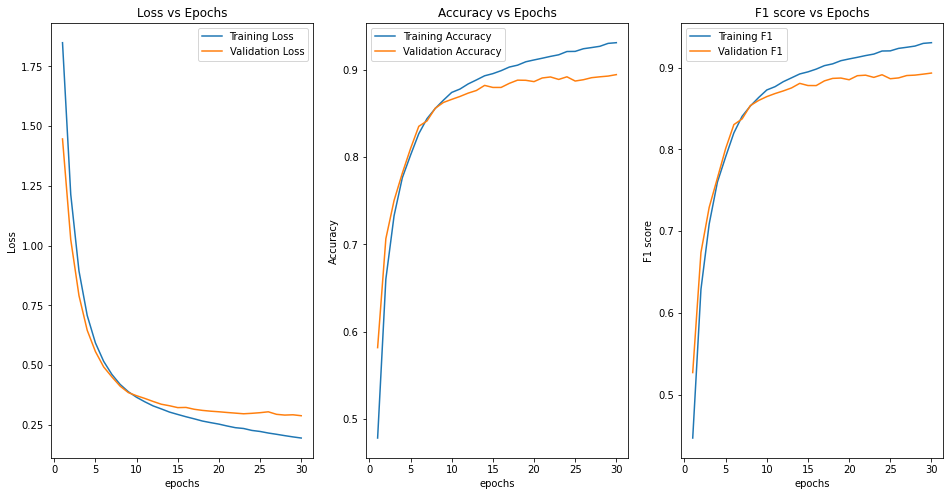

Loading model at epoch 30 for best validation f1
Preparing test loaders
Result on labelled test set  : Loss: 0.3643 Accuracy: 0.8696 F1_score: 0.8714
Result on unlabelled test set: Loss: 2.0664 Accuracy: 0.6857 F1_score: 0.6730
Result on full test set      : Loss: 0.8737 Accuracy: 0.8144 F1_score: 0.8085


In [10]:
whole_flow(4, True)

## Approach #6, use Gaussian Mixture with Auto Encoder to compute label for unlabelled data

Getting train and validate dataloaders for mode 5: clustering: Gaussian Mixture with Auto Encoder
Labeling unlabeled data...
Training Auto Encoder...


/ssd/jason_ssd/AdaptToNewClass/mylibs/loss.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log2pi = torch.log(torch.tensor(2.0 * torch.as_tensor(np.pi)))
/ssd/jason_ssd/AdaptToNewClass/mylibs/loss.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.sum(-0.5 * ((sample - mean) ** 2.0 * torch.exp(torch.tensor(-logvar)) + logvar + log2pi), dim=raxis)


Epoch: 1 Loss: {'loss': 368.93738191731774}
Epoch: 2 Loss: {'loss': 320.82726127929686}
Epoch: 3 Loss: {'loss': 317.4619801269531}
Epoch: 4 Loss: {'loss': 316.2859282389323}
Epoch: 5 Loss: {'loss': 315.9476617675781}
Epoch: 6 Loss: {'loss': 315.54754375}
Epoch: 7 Loss: {'loss': 315.3139657714844}
Epoch: 8 Loss: {'loss': 315.0032361328125}
Epoch: 9 Loss: {'loss': 314.6484292317708}
Epoch: 10 Loss: {'loss': 314.68175266927085}
Epoch: 11 Loss: {'loss': 314.27091466471353}
Epoch: 12 Loss: {'loss': 314.34442755533854}
Epoch: 13 Loss: {'loss': 314.3051361002604}
Epoch: 14 Loss: {'loss': 314.1194011230469}
Epoch: 15 Loss: {'loss': 313.98986388346356}
Labeling accuracy: 0.3362222222222222
Start Training... ResNet
Epoch: 1
	Train      - Loss: 2.0507 Accuracy: 0.3306 F1_score: 0.2624
	Validation - Loss: 1.7648 Accuracy: 0.4647 F1_score: 0.3802
Epoch: 2
	Train      - Loss: 1.5125 Accuracy: 0.5307 F1_score: 0.4649
	Validation - Loss: 1.2995 Accuracy: 0.5683 F1_score: 0.5063
Epoch: 3
	Train      - 

<Figure size 432x288 with 0 Axes>

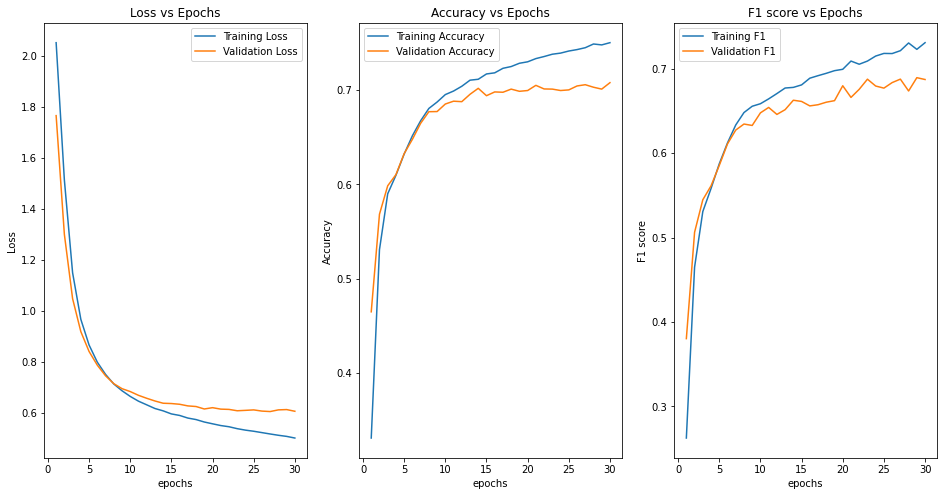

Loading model at epoch 29 for best validation f1
Preparing test loaders
Result on labelled test set  : Loss: 0.3663 Accuracy: 0.8691 F1_score: 0.8709
Result on unlabelled test set: Loss: 1.1304 Accuracy: 0.3223 F1_score: 0.2380
Result on full test set      : Loss: 0.5933 Accuracy: 0.7051 F1_score: 0.6783


In [14]:
whole_flow(5, True)

<Figure size 432x288 with 0 Axes>

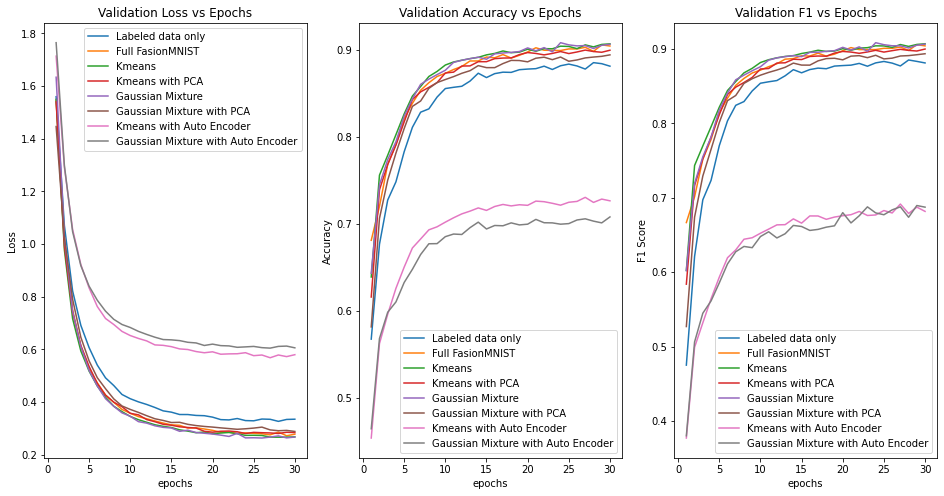

In [15]:
report_summary(mode_metrics, mode_description_short)

<Figure size 432x288 with 0 Axes>

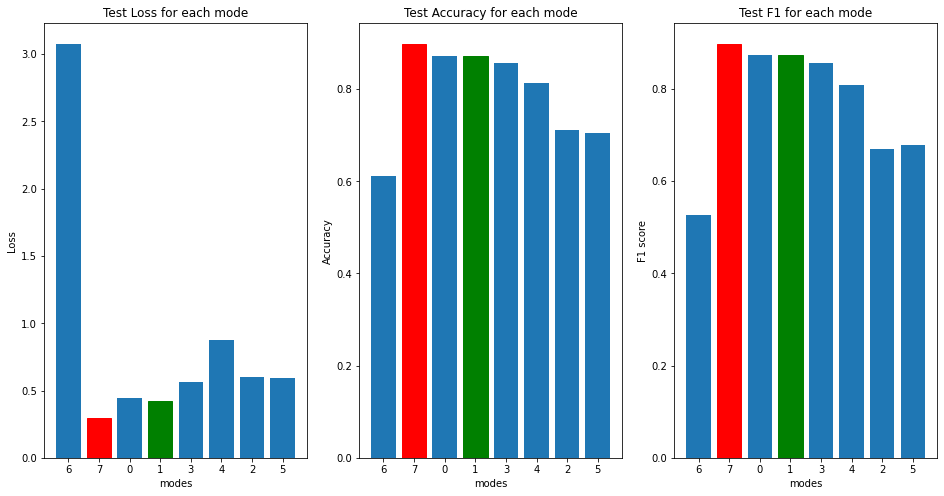

Mode Interpretations: 
    6: Labeled data only
    7: Full FasionMNIST
    0: Kmeans
    1: Kmeans with PCA
    3: Gaussian Mixture
    4: Gaussian Mixture with PCA
    2: Kmeans with Auto Encoder
    5: Gaussian Mixture with Auto Encoder
Color Interpretations: 
    Red  : Best result over all runs
    Green: Best result over all approachs (excluding baselines)


In [18]:
report_test_summary(mode_test_metrics, mode_description_short)

|                  Method              | Test Loss on Labeled Data | Test Accuracy on Labeled Data | Test F1 on Labeled Data | Test Loss on Unlabeled Data | Test Accuracy on Unlabeled Data | Test F1 on Unlabeled Data | Test Loss on All Data | Test Accuracy on All Data | Test F1 on All Data |
| ------------------------------------ | --------- | ------------- | ------- |------- |------- |------- |------- |------- |------- |
|  Baseline 1 - Only use Labeled data  |0.3572     | 0.8726        | 0.8729  |9.4141    | 0.0000        | 0.0000  | 3.0787 | 0.6108 | 0.5264
|                  KMeans              |0.3637     | 0.8716        | 0.8742  |0.6130    | 0.8737        | 0.8823  | 0.4424 | 0.8722 | 0.8729 
|            KMeans with PCA           |0.3700     | 0.8691        | 0.8723  |0.5518    | 0.8797        | 0.8892  | 0.4447 | 0.8723 | 0.8733 
|            KMeans with VAE           |0.3664     | 0.8707        | 0.8736  |1.1532    | 0.3393        | 0.2093  | 0.6043 | 0.7113 | 0.6698 
|            Gaussian Mixture          |0.3543     | 0.8730        | 0.8753  |1.0503    | 0.8207        | 0.8262  | 0.5620 | 0.8573 | 0.8565 
|        Gaussian Mixture with PCA     |0.3643     | 0.8696        | 0.8714  |2.0664    | 0.6857        | 0.6730  | 0.8737 | 0.8144 | 0.8085 
|        Gaussian Mixture with VAE     |0.3663     | 0.8691        | 0.8709  |1.1304    | 0.3223        | 0.2380  | 0.5933 | 0.7051 | 0.6783 
|  Baseline 2 - Full FashionMNIST data |0.3777     | 0.8690        | 0.8719  |0.0975    | 0.9683        | 0.9741  | 0.2934 | 0.8988 | 0.8984 
| Unsupervised Clustering | N/A | 0.551 | N/A | N/A | 0.8876 | N/A | N/A | 0.5603 | N/A |